## Make Online Discussions Less Toxic - One Comment at a time


### Overview

Wikipedia Talk Pages, also known as discussion pages, are the main way Wikipedia editors communicate with each other on Wikipedia. Every page on Wikipedia whether an article, or a Wiki project, a user page or something else has a corresponding talk page where editors discuss proposed changes, editing disagreements and other topics related to improving the article.

Discussions on Wikipedia are a crucial mechanism for editors to coordinate their work of curating the world’s knowledge. Unfortunately, discussions are not only the locus of coordination and cooperation; they are also a major avenue by which editors experience toxicity and harassment. Given a large number of Wikipedia talk pages, it is not possible to do manual evaluation of each and every comment posted. 

## Data

The dataset for this project comprises labeled comments from English Wikipedia by approximately 10 annotators via Crowdflower on a spectrum of how toxic the comment is (perceived as likely to make people want to leave the discussion) to how healthy to conversation the contribution is.

## Import all the necessary modules

## Load training data

Load the training data from the csv file using Pandas dataframe. 

In [4]:
filepath = 'train.csv'
messages_train = read_csv(filepath) 
print 'Training set dim : ', messages_train.shape
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = messages_train[list_classes].values
messages_test = read_csv('test_labels.csv')
print 'Test set dim : ',messages_test.shape

Training set dim :  (159571, 8)
Test set dim :  (63978, 8)


# Exploratory Data Analysis

## Plot distribution of comments length: 

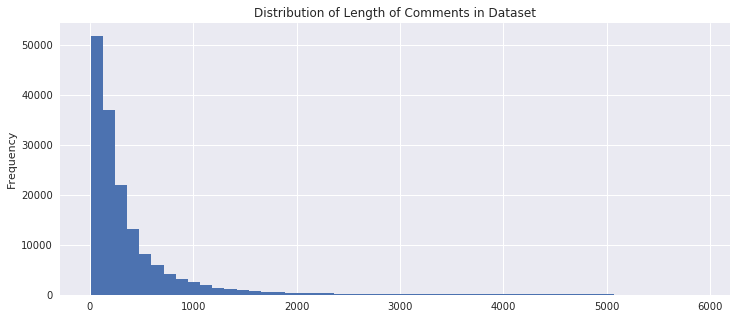

In [6]:
list_sentences_train = messages_train["comment_text"]
messages_train['comm_length'] = messages_train['comment_text'].map(len)

with sns.axes_style("darkgrid"):
    messages_train['comm_length'].plot(bins=50, kind='hist',figsize=(12,5), title='Distribution of Length of Comments in Dataset')


## Compare prevalance of toxic vs. non-toxic (clean) comments

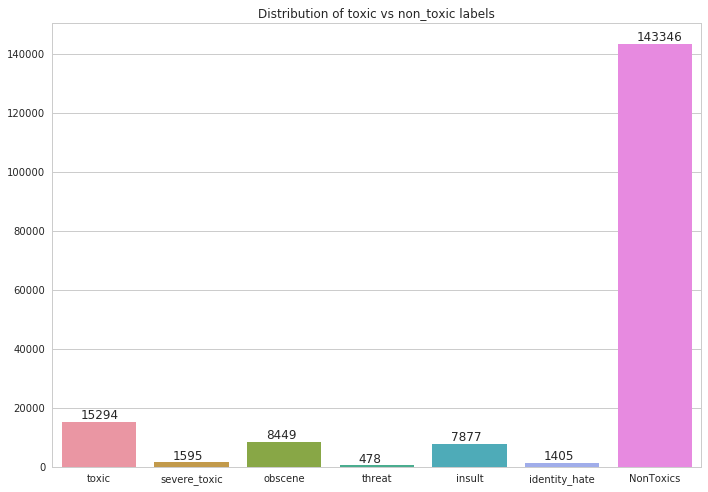

In [30]:
#Using data from the labeled columns, add a column that adds a new label 'Toxic' to show comments which are labelled
#toxic
min_text = messages_train.iloc[:,:8]         
sum_toxic_scores = min_text.iloc[:,2:].sum(axis=1) # get sum of each row, rows with zero sum are clean
min_text['NonToxics']=(sum_toxic_scores==0)  #NonToxic is 'True' for a clean comment
labels_sum = min_text.iloc[:,2:].sum() # sum each column to get totals for each column

#Plot a distribution of toxic vs. non_toxic labels
totals = []
with sns.color_palette("colorblind",):
    plt.figure(figsize=(10,7))
    ax = sns.barplot(labels_sum.index, labels_sum.values)
    #for value in labels_sum.values:
     #   ax.text(0.1,0.2,value)
    plt.title('Distribution of toxic vs non_toxic labels')
    for i in zip(ax.patches, labels_sum.values):
        height = i[0].get_height()
        ax.text(i[0].get_x()+0.2 , height, '{:.0f}'.format(i[1]), va='bottom')
        
    plt.tight_layout()

In [14]:
min_text['totals'] = messages_train.iloc[:,2:].sum(axis=1)

In [15]:
multi_tags =sum_toxic_scores.value_counts()

## Some tags have been assigned multiple tags

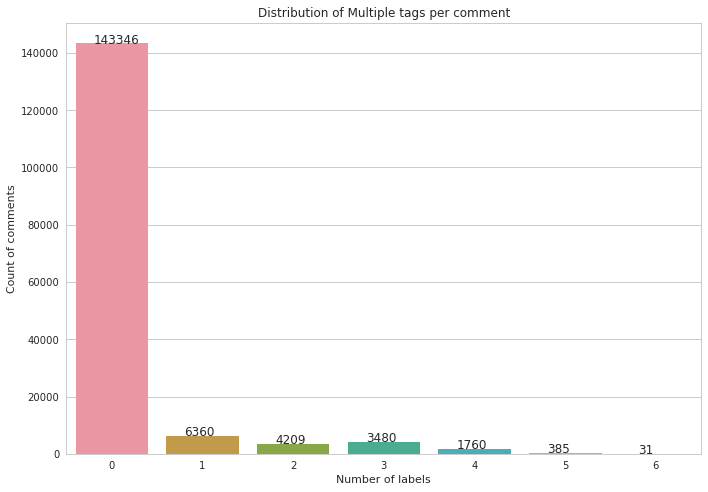

In [16]:
with sns.color_palette("colorblind"):
    plt.figure(figsize=(10,7))
    ax = sns.barplot(multi_tags.index, multi_tags.values)
    #for value in labels_sum.values:
     #   ax.text(0.1,0.2,value)
    plt.title('Distribution of Multiple tags per comment')
    plt.ylabel('Count of comments')
    plt.xlabel('Number of labels')
    for i in zip(ax.patches, multi_tags):
        height = i[0].get_height()
        ax.text(i[0].get_x()+0.2 , height + 6, '{:.0f}'.format(i[1]))
        
    plt.tight_layout()

## Another way to look at which comments are more likely to be toxic



Using cross tab of the comments tagged as toxic, we can identify which comments labels are likely to result in a toxic comment. Severe toxic comments are always labeled as toxic. 

In [20]:
temp_df = messages_train.iloc[:,2:]
temp = pd.crosstab(temp_df['toxic'],temp_df['severe_toxic'])
type(temp), temp.shape

(pandas.core.frame.DataFrame, (2, 2))

In [21]:
target_label = "toxic"
corr_mats=[]
for col in temp_df.columns[1:]:
    confusion_matrix = pd.crosstab(temp_df[target_label], temp_df[col])
    corr_mats.append(confusion_matrix)
out = pd.concat(corr_mats,axis=1,keys=temp_df.columns[1:])

#cell highlighting using pandas custom styling (https://pandas.pydata.org/pandas-docs/stable/style.html)
out = out.style.highlight_min(axis=0)
out

# Understanding the correlation of comments sub-type with toxic comments

The correlation matrix shows the comment sub-type which is more likely to be a toxic comment

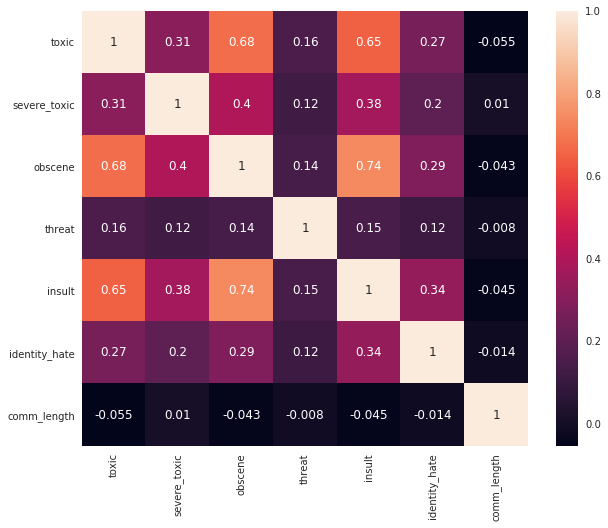

In [22]:
corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)

## Comments by label

In [21]:
labels_sum

toxic             15294.0
severe_toxic       1595.0
obscene            8449.0
threat              478.0
insult             7877.0
identity_hate      1405.0
NonToxics        143346.0
dtype: float64

In [23]:
toxic_ratio = 1- float(min_text['NonToxics'].sum())/messages_train.shape[0]

## Class Imbalance: Ratio of toxic comments

In [24]:
toxic_ratio

0.10167887648758234

10% of all comments are labeled as toxic. 

# Are there any missing values in training or test sets? 

In [25]:
print("Check for missing values in Train dataset")
null_check=messages_train.isnull().sum()
print(null_check)
print("Check for missing values in Test dataset")
null_check=messages_test.isnull().sum()
print(null_check)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
comm_length      0
dtype: int64
Check for missing values in Test dataset
id              0
comment_text    0
dtype: int64


In [531]:
min_text.head(1)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,NonToxics,totals
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,True,264


# Frequency of commonly occurring words by label type

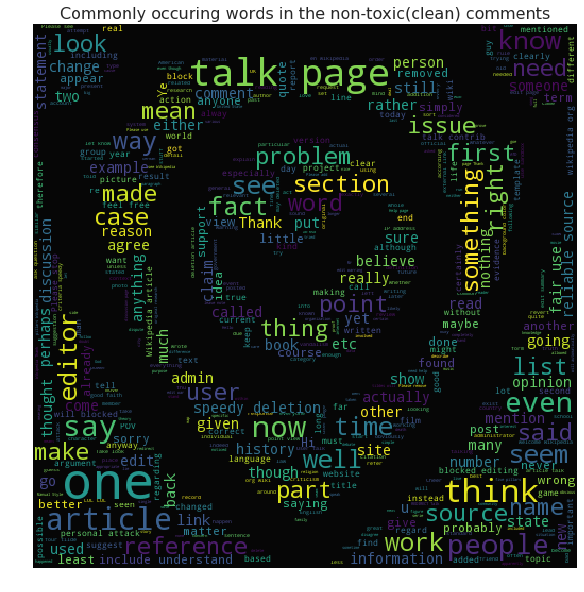

In [335]:
stopwords = set(STOPWORDS)
clean_mask=np.array(Image.open("images/safe-zone.png"))
clean_mask=clean_mask[:,:,1]
subset=min_text[min_text.NonToxics==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Commonly occuring words in the non-toxic(clean) comments", fontsize=16)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

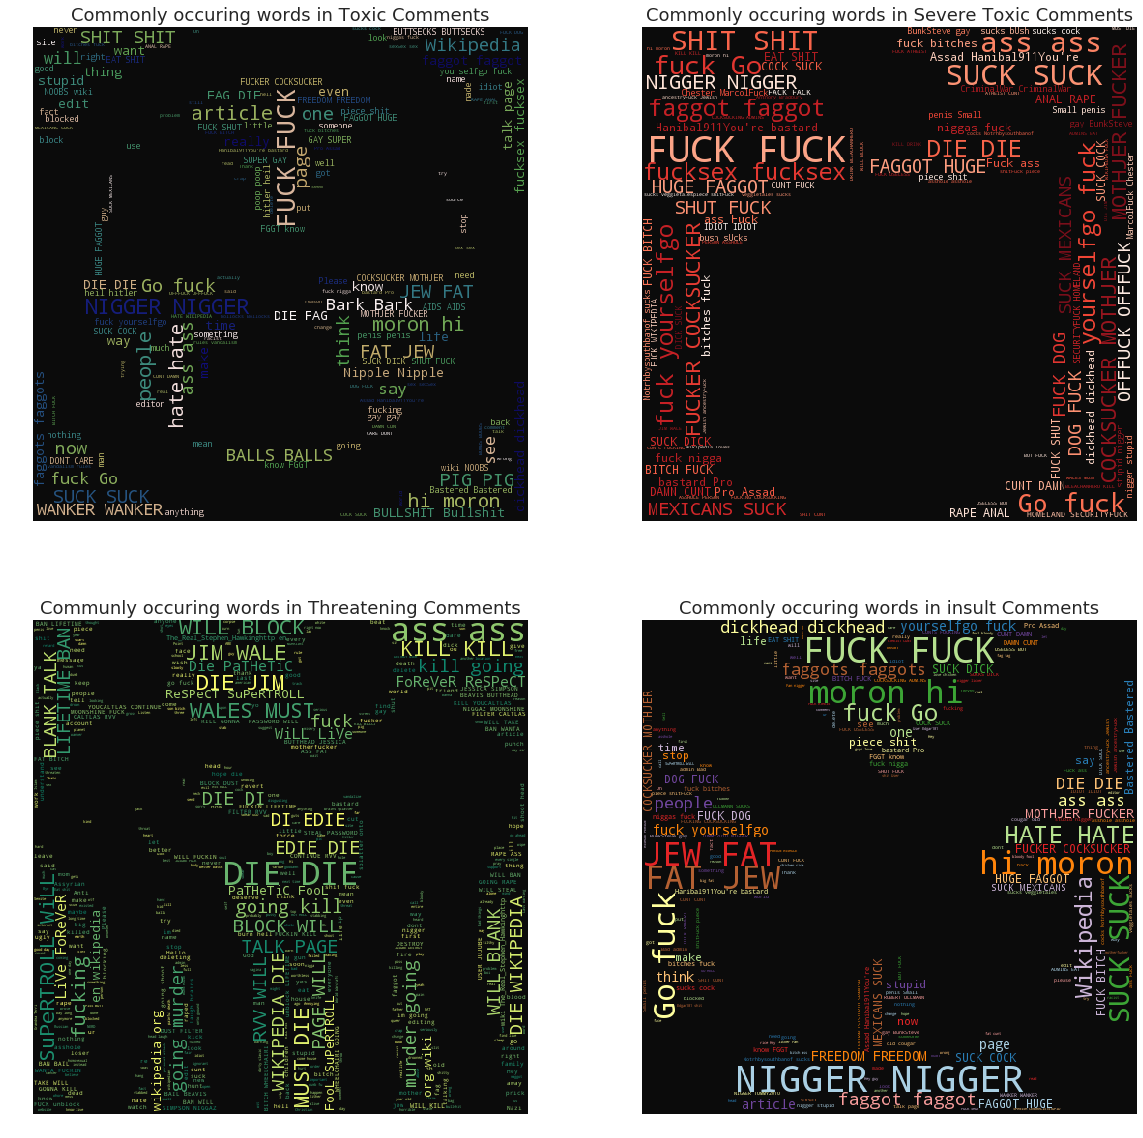

In [351]:
#Plot word cloud for each one of the other label types from the data set
#===========================
#Plot toxic comments word cloud
clean_mask=np.array(Image.open("images/toxic-sign.png"))
clean_mask=clean_mask[:,:,1]
subset=min_text[min_text.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,mask=clean_mask,stopwords=stopwords)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.axis("off")
plt.title("Commonly occuring words in Toxic Comments", fontsize=18)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=240), alpha=0.96)

#Severely toxic comments
clean_mask=np.array(Image.open("images/bomb.png"))
clean_mask=clean_mask[:,:,1]
plt.subplot(222)
subset=min_text[min_text['severe_toxic']==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopwords)
wc.generate(" ".join(text))

plt.axis("off")
plt.title("Commonly occuring words in Severe Toxic Comments", fontsize=18)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=223), alpha=0.96)

#Threat comments
clean_mask=np.array(Image.open("images/anger.png"))
clean_mask=clean_mask[:,:,1]
plt.subplot(223)
subset=min_text[min_text['threat']==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopwords)
wc.generate(" ".join(text))

plt.axis("off")
plt.title("Communly occuring words in Threatening Comments", fontsize=18)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=253), alpha=0.96)

#Insult
plt.subplot(224)
clean_mask=np.array(Image.open("images/swords.png"))
clean_mask=clean_mask[:,:,1]
subset=min_text[min_text['insult']==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,mask=clean_mask,stopwords=stopwords)
wc.generate(" ".join(text))

plt.axis("off")
plt.title("Commonly occuring words in insult Comments", fontsize=18)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.96)

plt.show()

# Train machine learning models on data

In [8]:
# fit a simple text classifier

#train_comments = comments.query("split=='train'")
#test_comments = comments.query("split=='test'")


X_train, X_test, y_train, y_test = train_test_split(messages_train['comment_text'], messages_train['toxic'], test_size=0.3, random_state=40)
clf = Pipeline([
    ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
    ('tfidf', TfidfTransformer(norm = 'l2')),
    ('clf', LogisticRegression()),
])

parameters = {
    'vect__max_df': (0.25, 0.5, 0.75),
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__C': [0.01, 0.1, 1],
    'clf__class_weight': ['balanced', None],
}

In [20]:
clf = clf.fit(X_train, y_train)

## Using roc_auc_score to get model performance on test set

In [10]:
auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print 'Test ROC AUC: %.3f' %auc

Test ROC AUC: 0.964


# Classification report

In [18]:
print classification_report(y_test, clf.predict(X_test))

             precision    recall  f1-score   support

          0       0.96      0.99      0.98     47516
          1       0.92      0.59      0.72      5143

avg / total       0.95      0.95      0.95     52659



In [22]:
clf.predict(["what the fuck is wrong"])

array([1])

## Using trained model to predict toxicity

In [23]:
label = {0: 'Non-toxic', 1: 'Toxic'}

### Example 1: 

In [27]:
example1 = ["Would you both shut up, you don't run wikipedia, especially a stupid kid."]

### Prediction

In [30]:
print 'Prediction: %s\nProbability: %.2f%%' %(label[clf.predict(example1)[0]],\
                                            clf.predict_proba(example1)[0][1]*100)

Prediction: Toxic
Probability: 99.50%


### Example 2:

In [32]:
example2 = ["Yeah i no that edit sucks"]

### Prediction

In [34]:
print 'Prediction: %s\nProbability: %.2f%%' %(label[clf.predict(example2)[0]],\
                                            clf.predict_proba(example2)[0][1]*100)

Prediction: Toxic
Probability: 91.45%


### Example 3

In [38]:
example3 = ["A pair of jew-hating weiner nazi schmucks."]

In [39]:
print 'Prediction: %s\nProbability: %.2f%%' %(label[clf.predict(example3)[0]],\
                                            clf.predict_proba(example3)[0][1]*100)

Prediction: Toxic
Probability: 83.00%


### Example 4

In [41]:
example4 = ["Why the edits made under my username Hardcore Metallica \
            Fan were reverted? They weren't vandalisms, \
            just closure on some GAs after I voted at New York Dolls FAC. \
            And please don't remove the template from the talk page since I'm retired now"]

In [42]:
print 'Prediction: %s\nProbability: %.2f%%' %(label[clf.predict(example4)[0]],\
                                            clf.predict_proba(example4)[0][1]*100)

Prediction: Non-toxic
Probability: 0.83%


## Future use cases

The machine learning models built for this project can also be tweaked to use on any online discussion forums to help moderate the online discussions on various platforms. 

## Thanks!